In [1]:
# Шаг 1
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt  # Для визуализации

In [2]:
# Шаг 2
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['Filename']
        img_path = os.path.join(self.root_dir, img_name)
        
        # Проверка существования файла
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Изображение не найдено: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx]['Label'])
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Шаг 3
# Пути к CSV-файлам и корневая папка
train_csv = '/home/andrey/Downloads/picture_classifier/data/EuroSAT/train.csv'
valid_csv = '/home/andrey/Downloads/picture_classifier/data/EuroSAT/validation.csv'
image_root_dir = '/home/andrey/Downloads/picture_classifier/data/EuroSAT'  # Корневая папка с папками классов


In [4]:
# Шаг 4
# Применяем трансформации
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [5]:
# Шаг 5
# Создаем кастомный датасет и DataLoader
train_dataset = CustomDataset(csv_file=train_csv, root_dir=image_root_dir, transform=train_transforms)
valid_dataset = CustomDataset(csv_file=valid_csv, root_dir=image_root_dir, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Размер загруженных изображений: torch.Size([32, 3, 224, 224])
Размер загруженных меток: torch.Size([32])


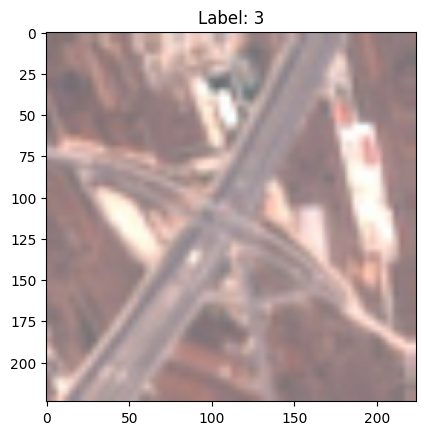

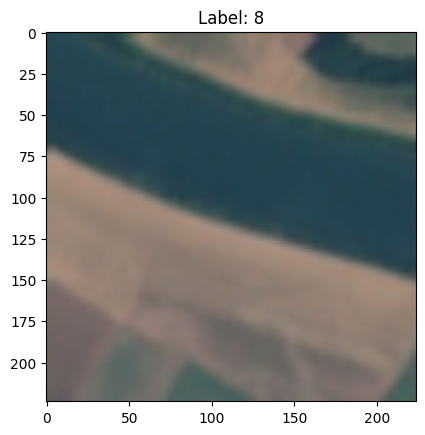

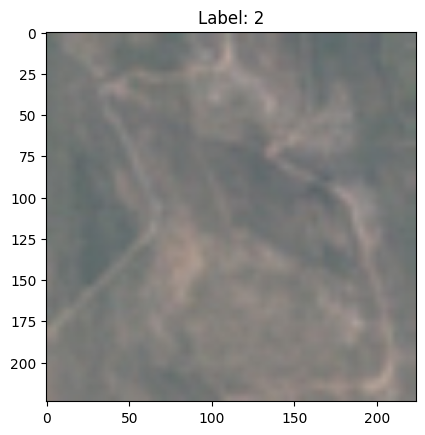

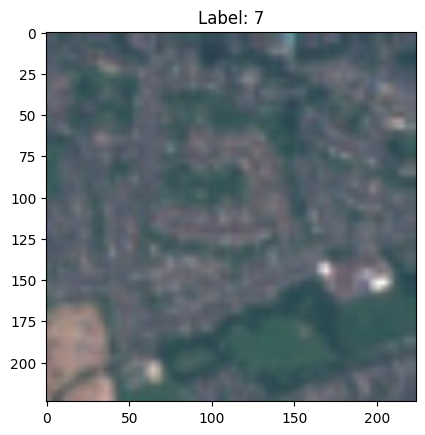

In [6]:
# Шаг 6
# Проверка работы DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Размер загруженных изображений: {images.shape}")
print(f"Размер загруженных меток: {labels.shape}")

# Визуализация нескольких изображений
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Обратная нормализация
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Отобразим первые 4 изображения и их метки
import numpy as np
for i in range(4):
    imshow(images[i], f"Label: {labels[i].item()}")

In [7]:
# Шаг 7
# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Количество классов
num_classes = len(train_dataset.annotations['Label'].unique())
print(f"Количество классов: {num_classes}")

Используемое устройство: cuda
Количество классов: 10


In [8]:
# Шаг 8
# Модель 1: ResNet-50
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# Модель 2: EfficientNet-B0
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)
efficientnet_model = efficientnet_model.to(device)

/home/andrey/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andrey/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Шаг 9
# Замораживаем все параметры, кроме последнего слоя
for param in resnet_model.parameters():
    param.requires_grad = False
resnet_model.fc.weight.requires_grad = True
resnet_model.fc.bias.requires_grad = True

for param in efficientnet_model.parameters():
    param.requires_grad = False
efficientnet_model.classifier[1].weight.requires_grad = True
efficientnet_model.classifier[1].bias.requires_grad = True

In [10]:
# Шаг 10
# Определяем функцию потерь и оптимизаторы
criterion = nn.CrossEntropyLoss()

optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
optimizer_efficientnet = optim.Adam(efficientnet_model.classifier[1].parameters(), lr=0.001)


In [11]:
# Шаг 11
# --- Функция для обучения ---
def train_model(model, optimizer, num_epochs=10):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)

            # Потери и оптимизация
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        val_accuracy = evaluate_model(model)  # Оценка на валидации

        print(f"Эпоха [{epoch+1}/{num_epochs}], Потеря: {epoch_loss:.4f}, Точность на валидации: {val_accuracy:.2f}%")

        # Сохранение лучшей модели
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')


In [12]:
# Шаг 12
# --- Функция для оценки ---
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [13]:
# Шаг 13
# --- Обучение и оценка ResNet-50 ---
print("\nОбучение модели ResNet-50")
train_model(resnet_model, optimizer_resnet, num_epochs=20)  # Увеличено количество эпох
resnet_model.load_state_dict(torch.load('best_model.pth'))  # Загрузка лучшей модели
resnet_accuracy = evaluate_model(resnet_model)
print(f'Точность ResNet-50 на валидации: {resnet_accuracy:.2f}%')



Обучение модели ResNet-50
Эпоха [1/20], Потеря: 0.4987, Точность на валидации: 91.54%
Эпоха [2/20], Потеря: 0.2997, Точность на валидации: 93.02%
Эпоха [3/20], Потеря: 0.2653, Точность на валидации: 93.91%
Эпоха [4/20], Потеря: 0.2418, Точность на валидации: 92.65%
Эпоха [5/20], Потеря: 0.2355, Точность на валидации: 94.00%
Эпоха [6/20], Потеря: 0.2248, Точность на валидации: 93.54%
Эпоха [7/20], Потеря: 0.2150, Точность на валидации: 94.54%
Эпоха [8/20], Потеря: 0.2174, Точность на валидации: 94.43%
Эпоха [9/20], Потеря: 0.2107, Точность на валидации: 94.70%
Эпоха [10/20], Потеря: 0.2070, Точность на валидации: 94.70%
Эпоха [11/20], Потеря: 0.1979, Точность на валидации: 93.56%
Эпоха [12/20], Потеря: 0.1924, Точность на валидации: 94.28%
Эпоха [13/20], Потеря: 0.1949, Точность на валидации: 93.59%
Эпоха [14/20], Потеря: 0.1899, Точность на валидации: 94.33%
Эпоха [15/20], Потеря: 0.1800, Точность на валидации: 94.07%
Эпоха [16/20], Потеря: 0.1836, Точность на валидации: 94.35%
Эпоха 

/tmp/ipykernel_184870/1172807272.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('best_model.pth'))  # Загрузка лучшей модели


Точность ResNet-50 на валидации: 94.70%


In [14]:
# Шаг 14
# --- Обучение и оценка EfficientNet-B0 ---
print("\nОбучение модели EfficientNet-B0")
train_model(efficientnet_model, optimizer_efficientnet, num_epochs=20)
efficientnet_model.load_state_dict(torch.load('best_model.pth'))
efficientnet_accuracy = evaluate_model(efficientnet_model)
print(f'Точность EfficientNet-B0 на валидации: {efficientnet_accuracy:.2f}%')


Обучение модели EfficientNet-B0
Эпоха [1/20], Потеря: 0.5962, Точность на валидации: 90.04%
Эпоха [2/20], Потеря: 0.3659, Точность на валидации: 91.89%
Эпоха [3/20], Потеря: 0.3319, Точность на валидации: 92.54%
Эпоха [4/20], Потеря: 0.3151, Точность на валидации: 92.44%
Эпоха [5/20], Потеря: 0.3061, Точность на валидации: 92.85%
Эпоха [6/20], Потеря: 0.2886, Точность на валидации: 93.09%
Эпоха [7/20], Потеря: 0.2866, Точность на валидации: 93.26%
Эпоха [8/20], Потеря: 0.2897, Точность на валидации: 93.02%
Эпоха [9/20], Потеря: 0.2914, Точность на валидации: 93.17%
Эпоха [10/20], Потеря: 0.2832, Точность на валидации: 92.69%
Эпоха [11/20], Потеря: 0.2757, Точность на валидации: 92.13%
Эпоха [12/20], Потеря: 0.2757, Точность на валидации: 92.41%
Эпоха [13/20], Потеря: 0.2750, Точность на валидации: 93.19%
Эпоха [14/20], Потеря: 0.2703, Точность на валидации: 93.09%
Эпоха [15/20], Потеря: 0.2818, Точность на валидации: 93.41%
Эпоха [16/20], Потеря: 0.2766, Точность на валидации: 93.28%


/tmp/ipykernel_184870/3822055789.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load('best_model.pth'))


Точность EfficientNet-B0 на валидации: 93.41%


In [15]:
# Шаг 15
# --- Сравнение моделей ---
print("\nСравнение моделей:")
print(f"ResNet-50 точность на валидации: {resnet_accuracy:.2f}%")
print(f"EfficientNet-B0 точность на валидации: {efficientnet_accuracy:.2f}%")


Сравнение моделей:
ResNet-50 точность на валидации: 94.70%
EfficientNet-B0 точность на валидации: 93.41%


In [17]:
# Шаг 16
# Сохранение ResNet-50
torch.save(resnet_model.state_dict(), '/home/andrey/Downloads/picture_classifier/models/resnet50_eurosat.pth')
print("ResNet-50 сохранена в '/home/andrey/Downloads/picture_classifier/models/resnet50_eurosat.pth'")

# Сохранение EfficientNet-B0
torch.save(efficientnet_model.state_dict(), '/home/andrey/Downloads/picture_classifier/models/efficientnet_b0_eurosat.pth')
print("EfficientNet-B0 сохранена в '/home/andrey/Downloads/picture_classifier/models/efficientnet_b0_eurosat.pth'")

ResNet-50 сохранена в '/home/andrey/Downloads/picture_classifier/models/resnet50_eurosat.pth'
EfficientNet-B0 сохранена в '/home/andrey/Downloads/picture_classifier/models/efficientnet_b0_eurosat.pth'
